In [76]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
import numpy as np

In [77]:
df= pd.read_csv('/content/DFORE878891.csv')

## Row by Row batch processing
- Drop all X from Compare period
- Clean repeating as400id
- Create 3 vendTypes- MicroTxn, Cash, Stored Value
- Create TestType
- Filter by TestType and Do a  groupby/ crosstab on  test and control group on vends and vendAmt- 4 crosstab really



In [78]:
df1= df.loc[~(df.ComparePeriod=='X')]
df2= df1.loc[~df1.client_account_id.isin([4473069, 4403152, 2022296, 1520076, 7407369, 7407423])]
df2['TestType']= df2.loc[:,'flag'].map({'Existing': 'TxnFee', 'ExistingCntrl': 'TxnFee', 'New': 'DynamicPricing', 'NewCntrl': 'DynamicPricing'})
df2['venType']= df2.loc[:,'payment_type'].map(dict(zip(df2.payment_type.unique().tolist(), ['MicroTxn', 'Cash', 'MicroTxn', 'StoredVal', 'MicroTxn', 'MicroTxn'])))

# Crosstabs

## Txn Fees- Relative Difference of change of vends between May and June

In [79]:
tf1= df2.loc[df2.TestType== 'TxnFee']
tf11= pd.crosstab([tf1.venType, tf1.flag], tf1.ComparePeriod, tf1.vends, aggfunc='sum', margins=True ).iloc[:, :-1]
tf11['vendChng']= tf11.loc[:,'JunePeriod']- tf11.loc[:,'MayPeriod']

In [80]:
tf11

ComparePeriod            JunePeriod  MayPeriod  vendChng
venType   flag                                          
Cash      Existing            11181      12034      -853
          ExistingCntrl       54849      61710     -6861
MicroTxn  Existing             4354       6260     -1906
          ExistingCntrl        7320       6214      1106
StoredVal Existing             5635       3537      2098
          ExistingCntrl        7079       5582      1497
All                           90418      95337     -4919

In [81]:
tf1= df2.loc[df2.TestType== 'TxnFee']
tf12= pd.crosstab([tf1.venType, tf1.flag], tf1.ComparePeriod, tf1.vendAmt, aggfunc='sum', margins=True ).iloc[:, :-1]
tf12['vendAmtchng']= (tf12.loc[:,'JunePeriod']- tf12.loc[:,'MayPeriod'])

In [82]:
tf12

ComparePeriod            JunePeriod  MayPeriod  vendAmtchng
venType   flag                                             
Cash      Existing          1953400    2117475      -164075
          ExistingCntrl     8557230    9383522      -826292
MicroTxn  Existing           843475    1087025      -243550
          ExistingCntrl     1257075    1067352       189723
StoredVal Existing           985600     620850       364750
          ExistingCntrl     1209900     949211       260689
All                        14806680   15225435      -418755

In [83]:
tf13= pd.crosstab([tf1.venType, tf1.flag, tf1.client_account_id], tf1.ComparePeriod, tf1.vends, aggfunc='sum').fillna(0).reset_index()
tf13.vendChange= None
tf13.loc[tf13.JunePeriod> tf13.MayPeriod,'venChange']= 'Growth'
tf13.loc[tf13.JunePeriod< tf13.MayPeriod,'venChange']= 'Decrease'
tf13.loc[tf13.JunePeriod== tf13.MayPeriod,'venChange']= 'NoChange'
tf14= tf13.groupby(['venType','venChange', 'flag'])['client_account_id'].agg('size').reset_index().pivot(index=['venType', 'venChange'], columns='flag', values= 'client_account_id')

## Dyanamic Pricing- Diffence in vends between Test/ Conrol in June 

In [84]:
tf2= df2.loc[(df2.TestType== 'DynamicPricing') & (df2.ComparePeriod== 'JunePeriod')]
tf21= pd.crosstab(tf2.venType, tf2.flag, tf2.vends, aggfunc='sum', margins=True ).iloc[:, :-1]
tf21['vendsChng']= (tf21.loc[:,'New']- tf21.loc[:,'NewCntrl'])

In [85]:
tf21

flag,New,NewCntrl,vendsChng
venType,,,
Cash,11523,8225,3298
MicroTxn,3301,1294,2007
StoredVal,4349,1879,2470
All,19173,11398,7775


In [86]:
tf22= pd.crosstab(tf2.venType, tf2.flag, tf2.vendAmt, aggfunc='mean', margins=True ).iloc[:, :-1]
tf22['vendChng']= (tf22.loc[:,'New']- tf22.loc[:,'NewCntrl'])

In [87]:
tf22

flag,New,NewCntrl,vendChng
venType,,,
Cash,21969.767442,17204.870130,4764.897312
MicroTxn,4068.204724,1781.268293,2286.936432
StoredVal,7624.358025,4696.926471,2927.431554
All,10284.472789,6952.470149,3332.002640


# Data Prep for T-Tests
- Pivot and create 2 dataframes- vends, vendAmt
- With vends
  - Create a new column 'allVends'
  - Calculate the % of 'allVends' as new columns- MicroTxnpct, StoredValpct etc
  - create new field for chngMicroVendpct, chngStoredValpct
  - Subset by TestType- Existing: tf1, New: tf2

In [116]:
tf5= tf1.groupby(['flag', 'client_account_id', 'ComparePeriod', 'venType'])['vends'].agg('sum').reset_index().\
pivot(index=['flag',	'client_account_id','ComparePeriod'], columns= 'venType', values= 'vends')
tf5['AllVends']=tf5.sum(axis=1)
# tf5['Cash']= tf5['Cash'].divide(tf5['AllVends'])
# tf5['MicroTxn']= tf5['MicroTxn'].divide(tf5['AllVends'])
# tf5['StoredVal']= tf5['StoredVal'].divide(tf5['AllVends'])
tf51= tf5.loc[:,'MicroTxn'].reset_index().pivot(index= ['flag', 'client_account_id'], columns='ComparePeriod', values= 'MicroTxn').fillna(0)
tf51['chngMicroVend']= tf51.JunePeriod- tf51.MayPeriod
tf51.groupby('flag').agg('describe')['chngMicroVend']
tf51.reset_index(inplace=True)
test= tf51.loc[tf51.flag== 'Existing', 'chngMicroVend'].values
cntrl= tf51.loc[tf51.flag== 'ExistingCntrl', 'chngMicroVend'].values

In [117]:
def draw_hist_z(test, cntrl, titl= 'Vends: change between May and June'):
  z_test= zscore(test, axis=0, ddof=1)
  z_cntrl= zscore(cntrl, axis=0, ddof=1)
  fig, ax = plt.subplots(figsize=(10,7))
  plt.hist(z_test, color='blue', density= True, bins=50,log=False, histtype='bar', axes=ax)
  plt.hist(z_cntrl, color='red', density= True, bins=50,log=False, histtype='bar', axes=ax)
  plt.legend(['Test', 'Control'])
  plt.axvline(np.mean(z_test), color='brown', linestyle='dashed', linewidth=1.5)
  plt.axvline(np.mean(z_cntrl), color='blue', linestyle='dashed', linewidth=1.5)
  plt.xlim(-5,5)
  plt.ylabel(titl)
  fig.tight_layout()
  plt.show()

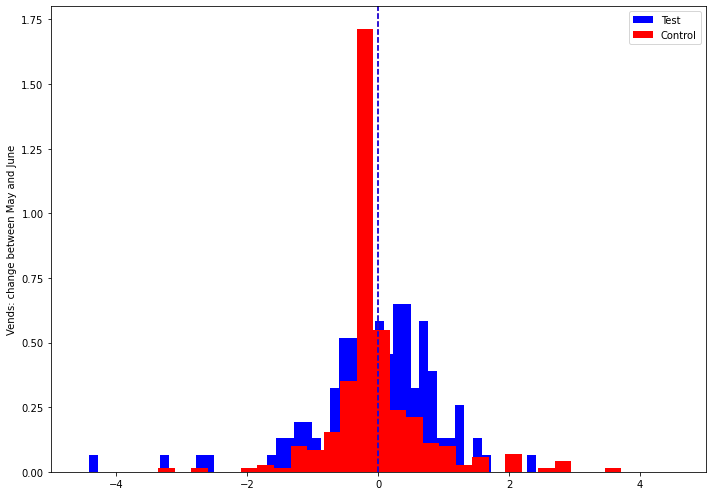

In [118]:
draw_hist_z(test, cntrl)

In [122]:
def plt_box(test, cntrl):
  p5= np.percentile(test, 5)
  p95= np.percentile(test, 95)
  t= test[np.where(np.logical_and(test>=p5, test<=p95))]
  p5= np.percentile(cntrl, 5)
  p95= np.percentile(cntrl, 95)
  c= cntrl[np.where(np.logical_and(cntrl>=p5, cntrl<=p95))]
  all_arr={'Test': t, 'Control': c]
  fig, ax = plt.subplots(figsize=(12,8))
  handles, _ = ax.get_legend_handles_labels() 
  ax.legend(handles, ["Test", "Control"], loc="best") 
  sns.boxplot(data=all_arr, ax=ax)
  plt.show()

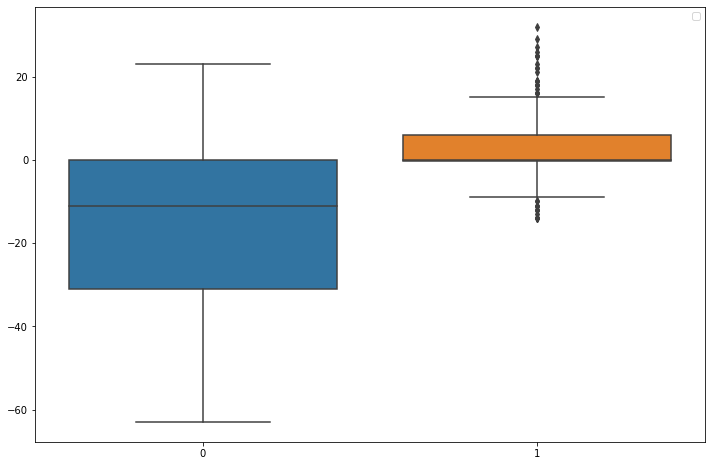

In [123]:
plt_box(test, cntrl)

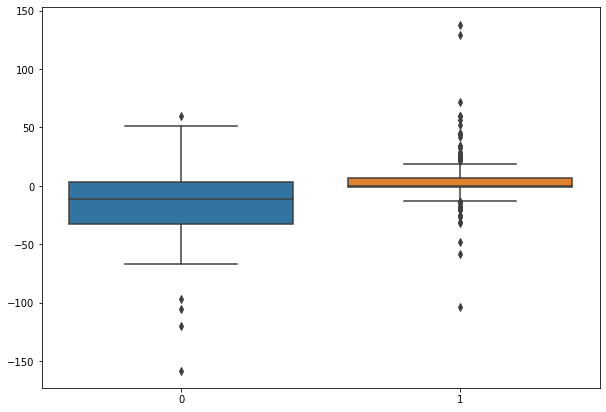

In [ ]:
all_arr=[test, cntrl]
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=all_arr, ax=ax)

In [ ]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

In [ ]:
welch_ttest(test, cntrl)


 Welch's t-test= 10.3303 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 145.6873


In [ ]:
stats.ttest_ind_from_stats(np.mean(test), np.std(test), len(test), \
                               np.mean(cntrl), np.std(cntrl), len(cntrl), \
                               equal_var=False)

Ttest_indResult(statistic=-6.493186203149472, pvalue=1.23973856859989e-09)

## Transaction Fee Test

In [ ]:
tf1

,flag,client_account_id,payment_type,ComparePeriod,vends,vendAmt,TestType,venType
0,Existing,1500167,CreditCard-SR,JunePeriod,1,200,TxnFee,MicroTxn
2,Existing,1500167,Coin,MayPeriod,48,6000,TxnFee,Cash
3,Existing,1500167,Coin,JunePeriod,36,4500,TxnFee,Cash
5,Existing,1500167,Apple-Pay,MayPeriod,7,1100,TxnFee,MicroTxn
6,Existing,1500167,Apple-Pay,JunePeriod,4,650,TxnFee,MicroTxn
...,...,...,...,...,...,...,...,...
3964,ExistingCntrl,7411124,Stored-Value,JunePeriod,3,300,TxnFee,StoredVal
3967,ExistingCntrl,7411124,Apple-Pay,MayPeriod,5,500,TxnFee,MicroTxn
3968,ExistingCntrl,7411124,Apple-Pay,JunePeriod,3,300,TxnFee,MicroTxn
3969,ExistingCntrl,7411125,Coin,MayPeriod,604,60400,TxnFee,Cash


# Welch T-Test
- Existing: tf1:-
  - chngMicroVendpct
    - ZScore
    - Plot
    - Welch T-Test
    - DDOF
  - chngStoredValpct
    - ZScore
    - Plot
    - Welch T-Test
    - DDOF
    
- New: tf2:-
  - MicroTxnpct
    - ZScore
    - Plot
    - Welch T-Test
    - DDOF
  - StoredValpct
    - ZScore
    - Plot
    - Welch T-Test
    - DDOF


  Test of Normality??

In [ ]:
test

ComparePeriod                 JunePeriod  ...      MayPeriod
payment_type               CreditCard-SR  ... Digital-Wallet
flag     client_account_id                ...               
Existing 30036                       1.0  ...            0.0
         30145                      17.0  ...            0.0
         30591                      22.0  ...            0.0
         31779                      12.0  ...            0.0
         33838                       0.0  ...            0.0
...                                  ...  ...            ...
NewCntrl 6520211                     8.0  ...            0.0
         6520222                    30.0  ...            0.0
         6520239                    11.0  ...            0.0
         6520278                    65.0  ...            0.0
         6874851                    18.0  ...            0.0

[582 rows x 12 columns]

In [ ]:
test['JunePeriod'].sum(axis=1)

flag      client_account_id
Existing  30036                 71.0
          30145                267.0
          30591                100.0
          31779                148.0
          33838                 30.0
                               ...  
NewCntrl  6520211              199.0
          6520222               87.0
          6520239              168.0
          6520278              275.0
          6874851              634.0
Length: 582, dtype: float64

In [ ]:
test['chngCoin']= test['JunePeriod']['Coin']- test['MayPeriod']['Coin']